In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import os
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt
import warnings

In [3]:
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=4, linewidth=130)
warnings.filterwarnings("ignore")
model_dir = os.getcwd()+"/model_dir"
os.makedirs(model_dir, exist_ok=True)

In [4]:
# Load a single agent of the environment
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [13]:
# Reset the environment    
env_info = env.reset(train_mode=True)[brain_name]     

# number of agents
num_agents = len(env_info.agents)

# size of each action
ENV_ACTION_SIZE = brain.vector_action_space_size

# size of the state space 
states = env_info.vector_observations
ENV_STATE_SIZE = states.shape[1]

print('Agents Num: {}\nState Shape (per agent): {}\nLen of action space: {}'.format(
    states.shape[0],
    ENV_STATE_SIZE,
    ENV_ACTION_SIZE
    )
)

Agents Num: 2
State Shape (per agent): 24
Len of action space: 2


In [6]:
def random_agents():    
    for i_episode in range(1, 6):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        t = 0
        while True:
            t+=1
            actions = np.random.randn(num_agents, ENV_ACTION_SIZE)
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += env_info.rewards
            states = next_states
            if np.any(dones):
                break
        print('Score (max over agents) from episode {}: {}'.format(i_episode, np.max(scores)))

random_agents()

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


# maddpg training

## plotting method

In [7]:
def plot(scores):
    '''plot scores'''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [8]:
from maddpg_agents import Maddpg
from hparams import *

def train(): 
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    # Instantiate the MADDPG agents
    maddpg = Maddpg(ENV_STATE_SIZE, ENV_ACTION_SIZE, num_agents, SEED)
    # Monitor the score    
    scores_deque = deque(maxlen=100)
    all_scores = []
    all_avg_score = []
    # Intialize amplitude OUNoise
    noise = NOISE
    all_steps = 0  
    for i_episode in range(NB_EPISODES+1):  
        env_info = env.reset(train_mode=True)[brain_name]
        maddpg.reset()
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        for steps in range(NB_STEPS):
            all_steps += 1
            actions = maddpg.act(states, noise)                    # retrieve actions to performe for each agents 
            noise *= NOISE_REDUCTION                               # Decrease action noise
            env_info = env.step(actions)[brain_name]               # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state for each agent
            rewards = env_info.rewards                             # get rewards (for each agent)
            dones = env_info.local_done                            # get episode end flags
            maddpg.step(states, actions, rewards, next_states, dones, i_episode)  # experiences => buffer + random sample experiences tuples for learning
            scores += env_info.rewards
            states = next_states
            if np.any(dones):
                break
        
        # Saving scores and computing metrics
        episode_score  = np.max(scores) # take the score of the leading agent
        all_scores.append(episode_score)
        scores_deque.append(episode_score)
        avg_score = np.mean(scores_deque)

        print('Episode {}\tAverage Score: {:.2f}\tEpisode score (max over agents): {:.2f}'.format(i_episode, avg_score, episode_score), end="\r")
        if i_episode > 0 and i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} (nb of total steps={}   noise={:.4f})'.format(i_episode, avg_score, all_steps, noise))
            maddpg.checkpoints()
            all_avg_score.append(avg_score)
        
        # Early stop
        if (i_episode > 99) and (avg_score >=0.5):
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
            maddpg.checkpoints()
            return all_scores

    return all_scores

Episode 100	Average Score: 0.01 (nb of total steps=1721   noise=1.0000)
Episode 200	Average Score: 0.01 (nb of total steps=3266   noise=1.0000)
Episode 300	Average Score: 0.00 (nb of total steps=4755   noise=1.0000)
Episode 400	Average Score: 0.01 (nb of total steps=6306   noise=1.0000)
Episode 500	Average Score: 0.02 (nb of total steps=7968   noise=1.0000)
Episode 600	Average Score: 0.01 (nb of total steps=9603   noise=1.0000)
Episode 700	Average Score: 0.02 (nb of total steps=11267   noise=1.0000)
Episode 800	Average Score: 0.03 (nb of total steps=13289   noise=1.0000)
Episode 900	Average Score: 0.05 (nb of total steps=15797   noise=1.0000)
Episode 1000	Average Score: 0.06 (nb of total steps=18385   noise=1.0000)
Episode 1100	Average Score: 0.09 (nb of total steps=21519   noise=1.0000)
Episode 1200	Average Score: 0.09 (nb of total steps=24825   noise=1.0000)
Episode 1300	Average Score: 0.11 (nb of total steps=28710   noise=1.0000)
Episode 1400	Average Score: 0.06 (nb of total steps=3

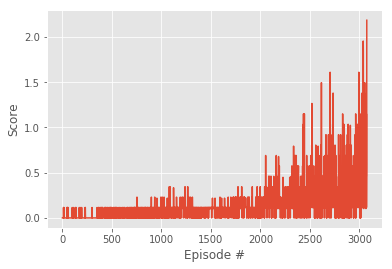

In [9]:
# Launch training
scores = train()
plot(scores)